In [24]:
#Dépendence
!pip install tqdm

# imports
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve

# Pour ignorer les messages d'avertissement
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


On dispose d’une base de données contenant 1797 images des 10 chiffres manuscrits.

Charger la base de données digits disponible sous sklearn.
Déterminer la dimension D des données et le nombre d’exemple par classe.

In [25]:
# chargement de la base de digits
digits = load_digits()
X = digits.data
y = digits.target

# split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,random_state=1)

#nombre d'exemples par classes
unique, counts = np.unique(y,return_counts=True)
print(dict(zip(unique, counts)))

# Observation d'une image
#plt.gray()
#plt.matshow(digits.images[8])
#plt.show()

{0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 182, 6: 181, 7: 179, 8: 174, 9: 180}


Entraîner le réseau (fonction fit). Optimiser la structure du réseau de neurones (nombre de cellules en couche cachée). Étudier l’influence du nombre de neurones cachés sur les taux de reconnaissance en apprentissage et en généralisation (fonction score). Conclure sur l’architecture optimale. Vous pouvez modifier les paramètres en fonction des conclusions tirées au TP2.

In [26]:
#learning rate
C = np.array([1,5,10,20,50,100,200,500,750,1000,1250,1500,1750,2000])

acc_test = []

for c in C:
    clf1 = MLPClassifier(hidden_layer_sizes=[c], activation='tanh', solver='adam', batch_size=100, alpha=0, learning_rate='adaptive')
    clf1.fit(X_train, y_train)
    acc_test.append(clf1.score(X_test, y_test))
    #score sur la base d'apprentissage
    #print(f"accuracy on training set for run {c}: {clf1.score(X_test, y_test)}" )

print('all results')
print(dict(zip(C, acc_test)))

best_acc_idx = np.argmax(acc_test)
print('best C = ', C[best_acc_idx]) #moyenne
print('best acc test =', acc_test[best_acc_idx])

# le nombre de neurones cachés améliore la précision, réduit l'écart-type et les loss.

all results
{1: 0.18888888888888888, 5: 0.8796296296296297, 10: 0.9462962962962963, 20: 0.9629629629629629, 50: 0.9814814814814815, 100: 0.9777777777777777, 200: 0.9796296296296296, 500: 0.9833333333333333, 750: 0.9851851851851852, 1000: 0.9851851851851852, 1250: 0.9888888888888889, 1500: 0.9888888888888889, 1750: 0.987037037037037, 2000: 0.987037037037037}
best C =  1250
best acc test = 0.9888888888888889


Afin d’améliorer les performances en généralisation du réseau de neurones, on se propose de mettre en œuvre un apprentissage avec arrêt précoce (early_stopping) par cross-validation.

Changer les paramètres du réseau pour séparer la base d’apprentissage précédente en deux sets : apprentissage (80%) et validation croisée (20% : validation _fraction=0.2).

Entraîner un réseau de neurones avec arrêt par cross-validation (fonction fit). Optimiser le nombre de neurones cachés C : répéter 10 fois l’apprentissage et calculer la moyenne et l’écart-type des taux en apprentissage et en validation afin de minimiser le biais et la variance (fonction score). Comparer avec les résultats obtenus précédemment. Conclure.

Conserver les poids du réseau optimal. Donner la matrice de confusion sur la base de test.

Comparer les résultats obtenus avec ceux de l’algorithme des k-plus-proches-voisins en termes de taux de reconnaissance et de temps de classification. Régler k sur une base de validation.

In [27]:
C = np.array([1,5,10,20,50,100,200,500,750,1000,1250,1500,1750,2000])

# Evaluation des paramètres
clf = MLPClassifier(activation='tanh', solver='adam', batch_size=100,alpha=0, learning_rate='adaptive',early_stopping=True, validation_fraction=0.2)

best_param_index = []
arr_train_scores = []
arr_validation_scores = []

# Entrainement 10 fois
for rep in tqdm(range(10)):
    train_scores, validation_scores = validation_curve(clf, X_train, y_train, param_name="hidden_layer_sizes",param_range=C,scoring="accuracy", n_jobs=6, cv=5)
    # retour des meilleur modèle, meilleur C et les scores associés
    idx_best_model = np.argmax(np.mean(validation_scores, axis=1))
    best_param_index.append(idx_best_model)
    mean = np.mean(validation_scores[idx_best_model])
    std = np.std(validation_scores[idx_best_model])

    print('\n====================================')
    print('Best model parameter: ', C[idx_best_model])
    print('Fold acc validation scores: ', validation_scores[idx_best_model])
    print('Mean validation scores: ', mean)
    print('Std validation scores: ', std)
    
    arr_train_scores.append(train_scores)
    arr_validation_scores.append(validation_scores)

# Choix de la valeur la plus présente
unique, counts = np.unique(best_param_index, return_counts=True)
C_best_consistent_index = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[0][0]

# Scores
train_scores = [score[C_best_consistent_index] for score in arr_train_scores]
train_scores = np.concatenate(train_scores)
validation_scores = [score[C_best_consistent_index] for score in arr_validation_scores]
validation_scores = np.concatenate(validation_scores)

# Résultats du meilleur paramètre
print('\n======= Result ========= ')
print('C = ', C[C_best_consistent_index])
print('mean train accuracy = ', np.mean(train_scores)) # moyenne
print('std train accuracy = ', np.std(train_scores)) # écart-type

print('mean kfold validation accuracy = ', np.mean(validation_scores)) # moyenne
print('std kfold validation accuracy = ', np.std(validation_scores)) # écart-type

# meme resultat = crossval validé
# résultats pas comparable = handicap d'un coté & pas sur test

 10%|█         | 1/10 [00:23<03:32, 23.58s/it]


Best model parameter:  1250
Fold acc validation scores:  [0.95238095 0.98412698 0.99601594 0.98007968 0.96812749]
Mean validation scores:  0.9761462088155316
Std validation scores:  0.01485300180356418


 20%|██        | 2/10 [00:43<02:51, 21.40s/it]


Best model parameter:  750
Fold acc validation scores:  [0.97619048 0.97222222 0.98406375 0.96812749 0.96812749]
Mean validation scores:  0.97374628470246
Std validation scores:  0.005964705068944934


 30%|███       | 3/10 [01:02<02:23, 20.45s/it]


Best model parameter:  1750
Fold acc validation scores:  [0.96428571 0.98412698 0.98406375 0.97609562 0.96812749]
Mean validation scores:  0.9753399102004681
Std validation scores:  0.008100658091909031


 40%|████      | 4/10 [01:24<02:06, 21.06s/it]


Best model parameter:  1000
Fold acc validation scores:  [0.9484127  0.98015873 0.98804781 0.98406375 0.97609562]
Mean validation scores:  0.9753557199772338
Std validation scores:  0.014046078343495529


 50%|█████     | 5/10 [01:46<01:46, 21.20s/it]


Best model parameter:  500
Fold acc validation scores:  [0.94047619 0.98412698 1.         0.96414343 0.97211155]
Mean validation scores:  0.9721716309365711
Std validation scores:  0.019931910192700734


 60%|██████    | 6/10 [02:11<01:29, 22.44s/it]


Best model parameter:  1750
Fold acc validation scores:  [0.9484127  0.98015873 0.98804781 0.98007968 0.97211155]
Mean validation scores:  0.9737620944792258
Std validation scores:  0.01363984346766258


 70%|███████   | 7/10 [02:36<01:10, 23.39s/it]


Best model parameter:  1500
Fold acc validation scores:  [0.96428571 0.98412698 0.99203187 0.96015936 0.97211155]
Mean validation scores:  0.9745430974514641
Std validation scores:  0.011964332664957259


 80%|████████  | 8/10 [02:58<00:46, 23.08s/it]


Best model parameter:  1000
Fold acc validation scores:  [0.96428571 0.96825397 0.99601594 0.97211155 0.97609562]
Mean validation scores:  0.9753525580218808
Std validation scores:  0.01105347414051142


 90%|█████████ | 9/10 [03:20<00:22, 22.60s/it]


Best model parameter:  1500
Fold acc validation scores:  [0.94444444 0.97619048 0.98804781 0.97211155 0.97211155]
Mean validation scores:  0.9705811673939163
Std validation scores:  0.014313352909138755


100%|██████████| 10/10 [03:42<00:00, 22.27s/it]


Best model parameter:  1250
Fold acc validation scores:  [0.97222222 0.97222222 0.98804781 0.98804781 0.96414343]
Mean validation scores:  0.9769366976538292
Std validation scores:  0.009539747685369762

======= Result ========= 
C =  1000
mean train accuracy =  0.9943518392134753
std train accuracy =  0.0028358432291224604
mean kfold validation accuracy =  0.9696986656548411
std kfold validation accuracy =  0.014602451715212569


In [28]:
K = [1, 2, 3, 5, 8, 10, 12, 15, 18, 21]

#Evaluation des paramètres
k_NN = KNeighborsClassifier(algorithm='brute', n_jobs=6)

best_param_index = []
arr_train_scores = []
arr_validation_scores = []

# Entrainement 10 fois
for rep in tqdm(range(10)):
    train_scores, validation_scores = validation_curve(k_NN, X_train, y_train, param_name="n_neighbors",param_range=K,scoring="accuracy", n_jobs=6, cv=5)
    idx_best_model = np.argmax(np.mean(validation_scores, axis=1))
    best_param_index.append(idx_best_model)
    mean = np.mean(validation_scores[idx_best_model])
    std = np.std(validation_scores[idx_best_model])

    print('\n====================================')
    print('Best model parameter: ', K[idx_best_model])
    print('Fold acc validation scores: ', validation_scores[idx_best_model])
    print('Mean validation scores: ', mean)
    print('Std validation scores: ', std)
    
    arr_train_scores.append(train_scores)
    arr_validation_scores.append(validation_scores)

# Choix de la valeur la plus présente
unique, counts = np.unique(best_param_index, return_counts=True)
K_best_consistent_index = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[0][0]

# Scores
train_scores = [score[K_best_consistent_index] for score in arr_train_scores]
train_scores = np.concatenate(train_scores)
validation_scores = [score[K_best_consistent_index] for score in arr_validation_scores]
validation_scores = np.concatenate(validation_scores)

# Résultats du meilleur paramètre
print('\n======= Result ========= ')
print('K = ', K[K_best_consistent_index])
print('mean train accuracy = ', np.mean(train_scores)) # moyenne
print('std train accuracy = ', np.std(train_scores)) # écart-type

print('mean kfold validation accuracy = ', np.mean(validation_scores)) # moyenne
print('std kfold validation accuracy = ', np.std(validation_scores)) # écart-type

 10%|█         | 1/10 [00:00<00:06,  1.41it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785


 20%|██        | 2/10 [00:01<00:04,  1.63it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785


 30%|███       | 3/10 [00:01<00:04,  1.67it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785


 40%|████      | 4/10 [00:02<00:03,  1.77it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785


 50%|█████     | 5/10 [00:02<00:02,  1.84it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785


 60%|██████    | 6/10 [00:03<00:02,  1.89it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785


 70%|███████   | 7/10 [00:03<00:01,  1.91it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785


 80%|████████  | 8/10 [00:04<00:01,  1.92it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785


 90%|█████████ | 9/10 [00:04<00:00,  1.94it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Best model parameter:  3
Fold acc validation scores:  [0.96825397 0.98412698 0.98007968 0.98406375 0.99601594]
Mean validation scores:  0.9825080629861507
Std validation scores:  0.008905952468621785

======= Result ========= 
K =  3
mean train accuracy =  0.9882664213722641
std train accuracy =  0.0020247318379744057
mean kfold validation accuracy =  0.9825080629861506
std kfold validation accuracy =  0.008905952468621785


In [29]:
#score K_NN cross-validation sur la base de test
k_NN = KNeighborsClassifier(n_neighbors=K[K_best_consistent_index],algorithm='brute', n_jobs=6)
k_NN.fit(X_train, y_train)
print(f"accuracy on test set for K = {K[K_best_consistent_index]}: {k_NN.score(X_test, y_test)}" )

#score MLP cross-validation sur la base de test
clf = MLPClassifier(hidden_layer_sizes=C[C_best_consistent_index], activation='tanh', solver='adam', batch_size=100,alpha=0, learning_rate='adaptive',early_stopping=True, validation_fraction=0.2)
clf.fit(X_train, y_train)
print(f"accuracy on test set for C = {C[C_best_consistent_index]}: {clf.score(X_test, y_test)}" )

#K_NN plus rapide, K_NN a un meilleur résultat.


accuracy on test set for K = 3: 0.9888888888888889
accuracy on test set for C = 1000: 0.9833333333333333


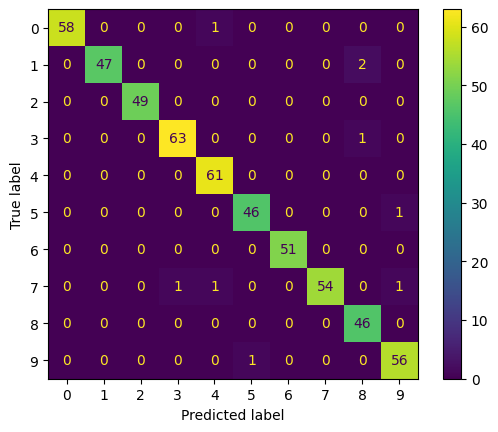

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test))

# L'algorithme des k-plus-proches-voisins permet un meilleur taux de reconnaissance 
# mais implique un temps de classification plus haut (à chaque valeur, un calcul est réalisé).

On se propose d’améliorer les performances précédentes en autorisant le rejet dans l’étape de décision. On étudiera successivement :

    le rejet de distance : argmax_reject_threshold
    le rejet d’ambigüité : argmax_top2_reject_threshold

On utilisera la fonction predict_proba pour obtenir les probabilités a posteriori des classes.

Faire varier le seuil (threshold) de 0 à 1 par pas de 10−2

. Pour chaque valeur, calculer :

    le taux de rejet (#exemple rejetés/#exemples total)
    le taux de reconnaissance (#exemple bien classés / #exemples classés)

Tracer dans les deux cas la courbe (taux de reconnaissance en fonction du taux de rejet). Choisir la méthode la plus efficace et le seuil associé (meilleur rapport #exemples bien classés / #exemples rejetés).

In [31]:
def argmax_reject_threshold(y, threshold):
    y_argmax = np.argmax(y, axis=1)
    y_masked = np.ma.array(y_argmax, mask=(np.amax(y, axis=1) < threshold))

    return y_masked.filled(-1)

def argmax_top2_reject_threshold(y, threshold):
    y_argmax = np.argmax(y, axis=1)
    y_top2 = np.sort(y, axis=1)[:,-1:-3:-1]
    y_masked = np.ma.array(y_argmax, mask=((y_top2[:,0] - y_top2[:,1]) < threshold))

    return y_masked.filled(-1)

y_test_pred = clf.predict_proba(X_test)

#rejet de distance
rejets = []
reconnaissances = []
for i in range (0, 100):
    # de 0 à 1, pas de 10^2
    filtered_pred = argmax_reject_threshold(y_test_pred, i/100)
    reconnaissances.append(np.sum(filtered_pred == y_test) / np.sum(filtered_pred != -1))
    rejets.append(np.sum(filtered_pred == -1) / len(y_test))

#rejet d'ambiguité
rejets_2 = []
reconnaissances_2 = []
for i in range (0, 100):
    # de 0 à 1, pas de 10^2
    filtered_pred = argmax_top2_reject_threshold(y_test_pred, i/100)
    reconnaissances_2.append(np.sum(filtered_pred == y_test) / np.sum(filtered_pred != -1))
    rejets_2.append(np.sum(filtered_pred == -1) / len(y_test))

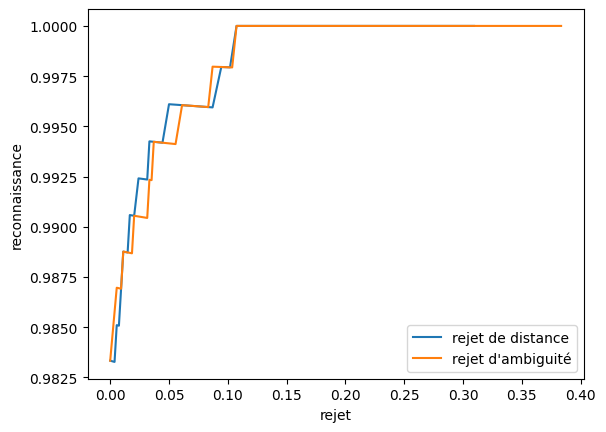

In [32]:
# Plot the data
plt.plot(rejets, reconnaissances, label='rejet de distance')
plt.plot(rejets_2, reconnaissances_2, label="rejet d'ambiguité")

# Axes
plt.xlabel('rejet')
plt.ylabel('reconnaissance')

# Legende
plt.legend()

# Affichage du graphe
plt.show()


# rejet de distance est mieux car il un a un taux de reconnaissance qui converge plus tôt

Utiliser l'algorithme des k-ppv pour classer les exemples rejetés. Calculer le taux d'erreur global de la cascade de classifieurs constituée de deux étages. Donner les matrices de confusion du 1er étage et de la cascade.

In [33]:
# prediction avec K_NN
y_test_pred_knn = k_NN.predict(X_test)
# rejet de distance avec K_NN
rejets = []
reconnaissances = []
# rejet de distance étage 1
filtered_pred_end = argmax_reject_threshold(y_test_pred, 0.20)
# classement des exemples rejetés du le modèle 1 (MLP) par le modèle 2 (K_NN)
filtered_pred_end = np.ma.where(filtered_pred_end == -1, y_test_pred_knn, filtered_pred_end)


In [36]:
# Matrice de confusion après l'étage 1 de la cascade
cm1 = confusion_matrix(y_test, clf.predict(X_test))
print("Confusion matrix 1st step cascade:")
print(cm1)

# Matrice de confusion en fin de cascade
cm2 = confusion_matrix(y_test, y_test_pred_knn)
print("\nConfusion matrix end of cascade:")
print(cm2)

Confusion matrix 1st step cascade:
[[58  0  0  0  1  0  0  0  0  0]
 [ 0 47  0  0  0  0  0  0  2  0]
 [ 0  0 49  0  0  0  0  0  0  0]
 [ 0  0  0 63  0  0  0  0  1  0]
 [ 0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  1]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  1  1  0  0 54  0  1]
 [ 0  0  0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  1  0  0  0 56]]

Confusion matrix end of cascade:
[[59  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  1  0  0]
 [ 0  0  1 63  0  0  0  0  0  0]
 [ 0  0  0  0 61  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  1]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 56  0  1]
 [ 0  1  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  1  0  0  0 56]]


In [35]:
cm_diff = cm2 - cm1
print(cm_diff)

# valeur > 1, erreurs de K_NN
# valeur < 1, retrait des erreurs de MLP
# somme = 0, autant de datapts donc validé

#CM2 > CM1



[[ 1  0  0  0 -1  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0 -2  0]
 [ 0  0 -1  0  0  0  0  1  0  0]
 [ 0  0  1  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1 -1  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
